# Objectness distribution in space
The purpose of this notebook is to vizualize how objectness changes when the bounding box is shifted from the ground truth location. For this purpose, let $n \times m$ be the size of the image $I$, and let $bb(t)=\{x,y,w,h\}$ be the bounding box at time $t$. Also, let $O_{edge}(x,y), O_{straddling}(x,y)$ be the function of edge and straddling objectness measure as functions of the center of the bounding box. The problem is to plot $O_{edge}, O_{straddling}$.

In [38]:
# Import C++ implementation of the objectness.
import sys
sys.path.append('../../Experiments')
import objectness

## Load Data
Load the image and corresponding bounding box.

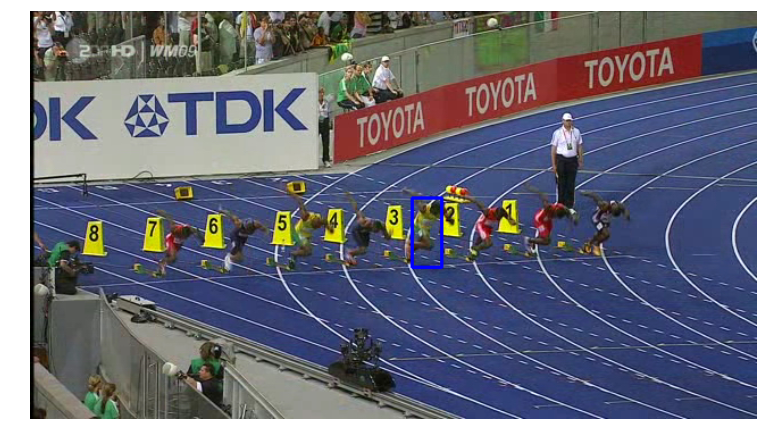

In [39]:
sys.path.append('../../Evaluation')
#from  Evaluation import  DatasetEvaluation
import DatasetEvaluation
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
### CHANGE THIS PARAETERS, IF NECESSARY
vidName="bolt"
imageNumber=0;

fig_x_size=13
fig_y_size=10

wu2013GroundTruth="/Users/Ivan/Files/Data/Tracking_benchmark"
datasetType='wu2013'

dataset=DatasetEvaluation.Dataset(wu2013GroundTruth,datasetType)
d=dataset.dictData;



# get the dictionary
vidDictionary=[x for x in d if x["name"]==vidName][0]
# get the bounding box
box=vidDictionary['boxes'][imageNumber]
# get the image
ImName=vidDictionary['images'][imageNumber]
I=cv2.imread(ImName)
I=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

pt1=(int(box[0]),int(box[1]))
pt2=(int(box[0]+box[2]),int(box[1]+box[3]))
cv2.rectangle(I,pt1,pt2,(0,0,255),2)
plt.figure(figsize=(fig_x_size, fig_y_size))
plt.imshow(I)
plt.axis("off")
plt.show()

In [40]:
box = np.round(box)


# create objectness object
objness = objectness.Objectness()

edge_t1 = 1
edge_t2 = 200
inner_rectangle = 0.95
nSuperpixels = 200

# needs around 1272 seconds per objectness measure
import os.path
import time

outfileEdge = vidName + '_edge_' + str(imageNumber) + '_3D';
outfileStraddling = vidName + '_straddling_' + str(imageNumber) + '_3D';

radius = 10;
minScaleLevel = -5;
maxScaleLevel = 10;
scaleChange = 1.05;

thirdDim = maxScaleLevel - minScaleLevel + 1;

if (not os.path.isfile(outfileEdge + '.npy')) or (not os.path.isfile(outfileStraddling + '.npy')):
    O_edge = np.zeros((I.shape[0], I.shape[1], thirdDim))
    O_straddling = np.zeros((I.shape[0], I.shape[1], thirdDim))
    t0 = time.time()
    print I.shape
    # iterate over all possible locations of the boundig box

    for scale in range(minScaleLevel, maxScaleLevel+1):
        print scale,
        width = box[2] * np.power(scaleChange, scale);
        height = box[3] * np.power(scaleChange, scale);
        for y in range(0, I.shape[0]):

            for x in range(0, I.shape[1]):

                if math.sqrt((x-box[0])**2+(y-box[1])**2)>radius:
                    continue;

                # create a bounding box centered at x,y
                b = [x - width / 2, y - height / 2, width, height]

                # make sure the bounding box fits the image
                if (b[0] < 0 or b[0] + width >= I.shape[1]) or (b[1] < 0 or b[1] + height >= I.shape[0]):
                    continue

                objness.initialize(ImName, int(b[0]), int(b[1]), int(width), int(height))

                if (not os.path.isfile(outfileEdge + '.npy')):
                    O_edge[y][x][scale - minScaleLevel] = objness.getEdgeness(edge_t1, edge_t2, inner_rectangle)

                if (not os.path.isfile(outfileStraddling + '.npy')):
                    O_straddling[y][x][scale - minScaleLevel] = objness.getStraddling(nSuperpixels, inner_rectangle)
        t1 = time.time()

        total_time = t1 - t0;
        np.save(outfileEdge, O_edge)
        np.save(outfileStraddling, O_straddling)
else:
    O_edge = np.load(outfileEdge + '.npy')
    O_straddling = np.load(outfileStraddling + '.npy')

In [41]:
# iterate for every scale -> find best location in the neighborhood of the true bounding box

R=60
bestEdgeBox=list()
bestStraddlingBox=list()
bestEdgeAndStraddlingBox=list()

import math
import copy

O_edge_copy=copy.deepcopy(O_edge)
O_straddling_copy=copy.deepcopy(O_straddling)

for scale in range(minScaleLevel, maxScaleLevel+1):
    print scale,
    width = box[2] * np.power(scaleChange, scale);
    height = box[3] * np.power(scaleChange, scale);
    
    for y in range(0, I.shape[0]):
    #print y, ;
        for x in range(0, I.shape[1]):
            
            if (math.sqrt((x-width/2.0-box[0])**2+(y-height/2.0 -box[1])**2))>R:
                O_straddling_copy[y][x][scale- minScaleLevel]=0
                O_edge_copy[y][x][scale- minScaleLevel]=0
                

-5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10


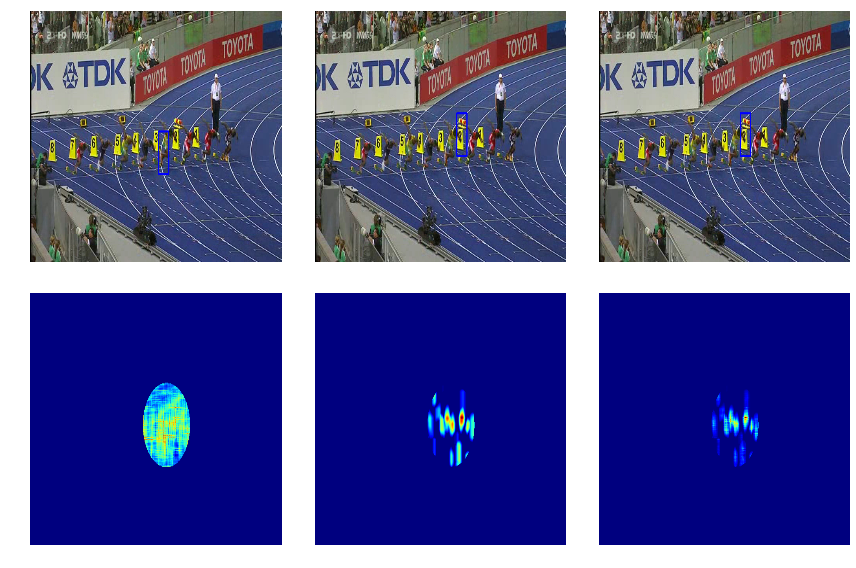

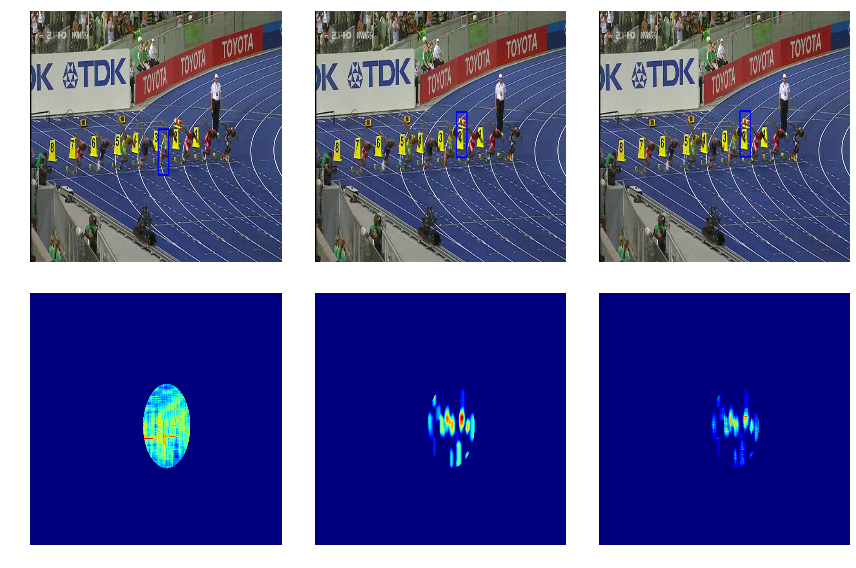

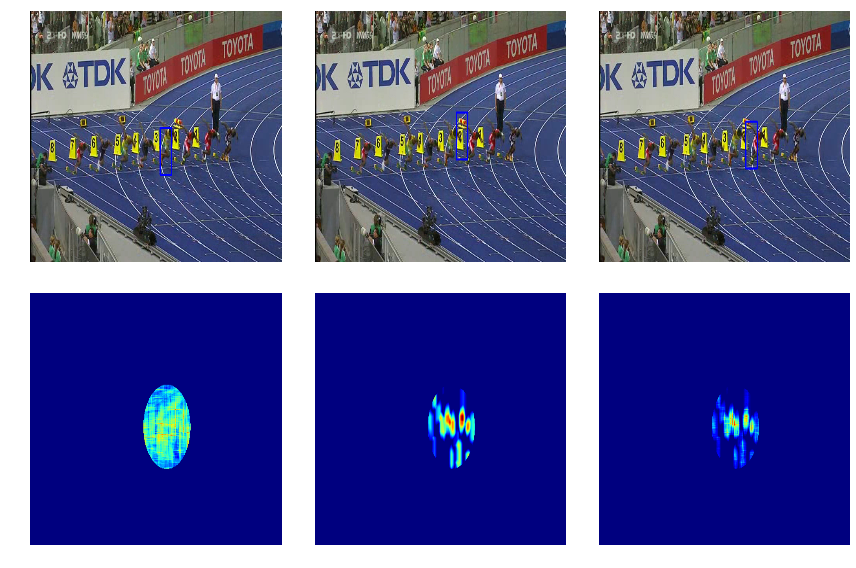

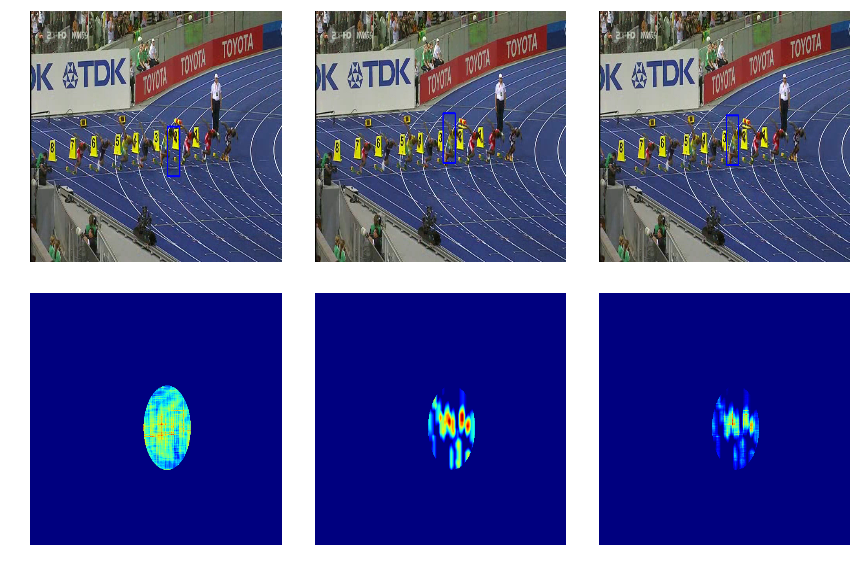

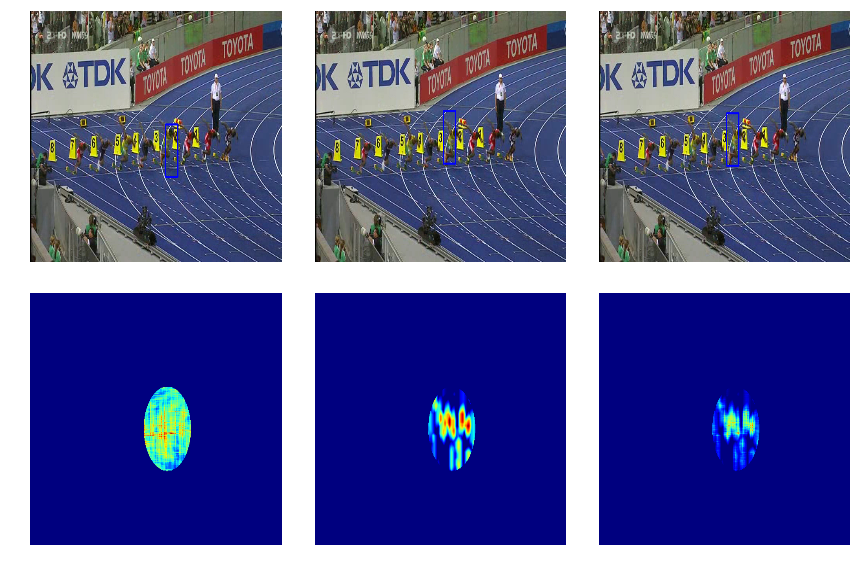

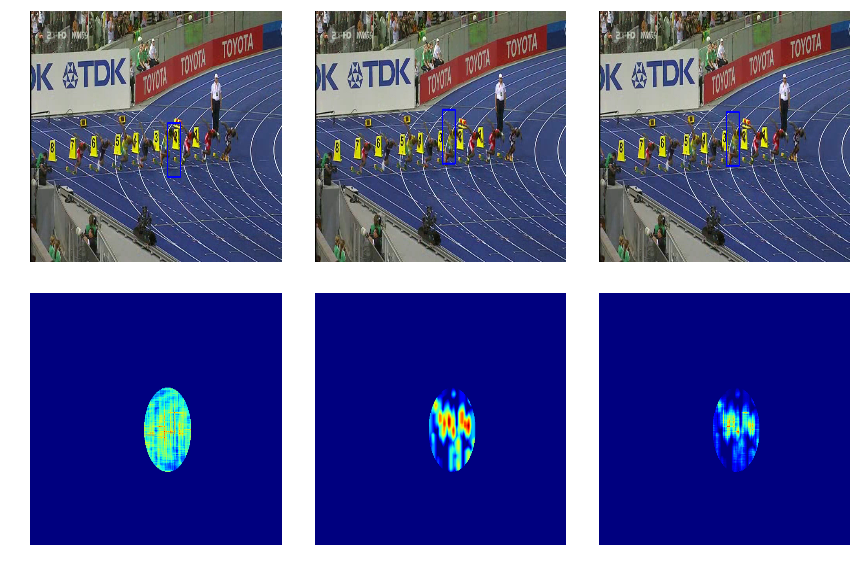

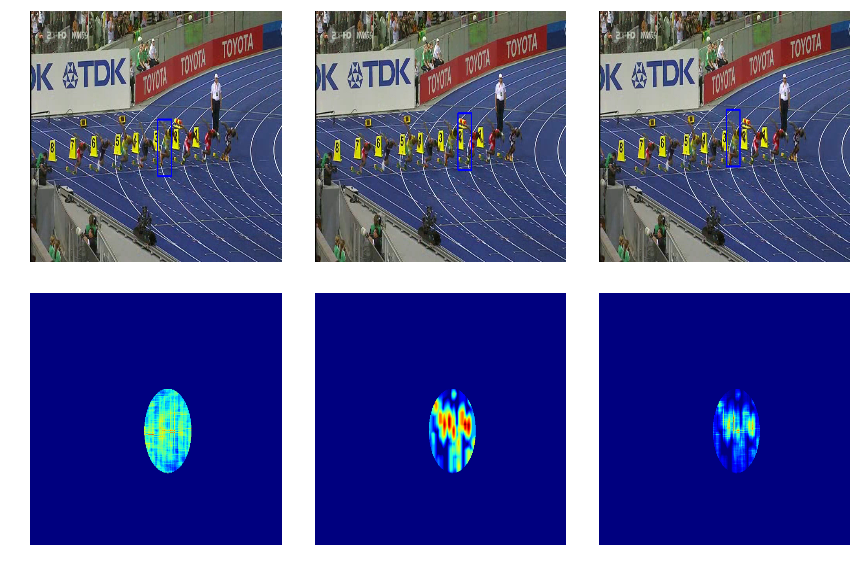

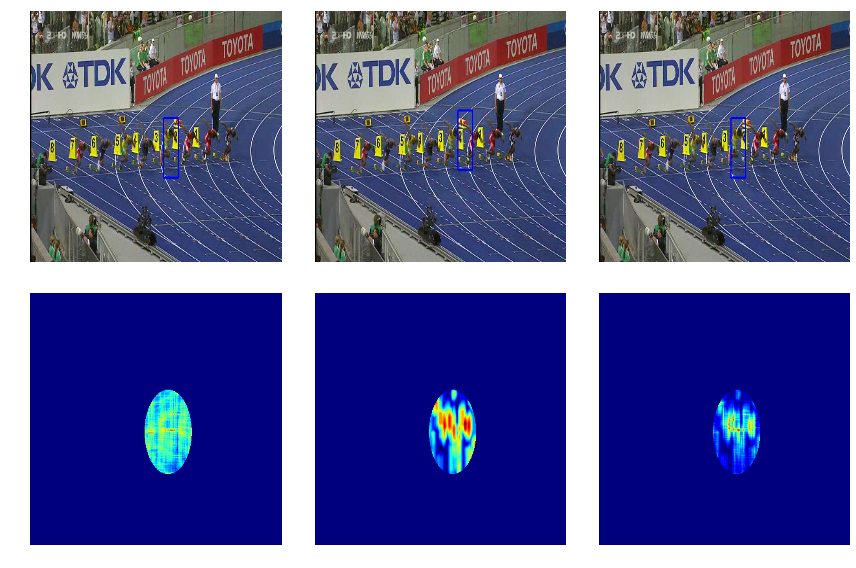

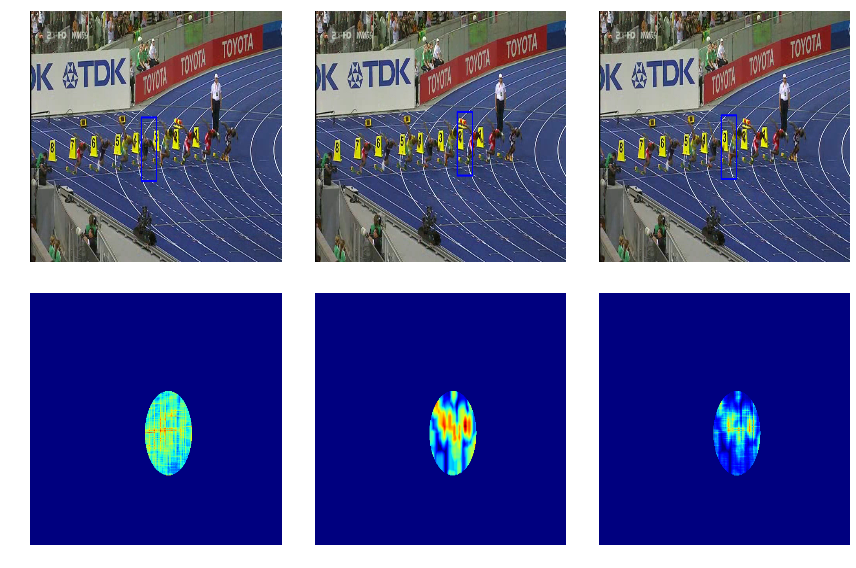

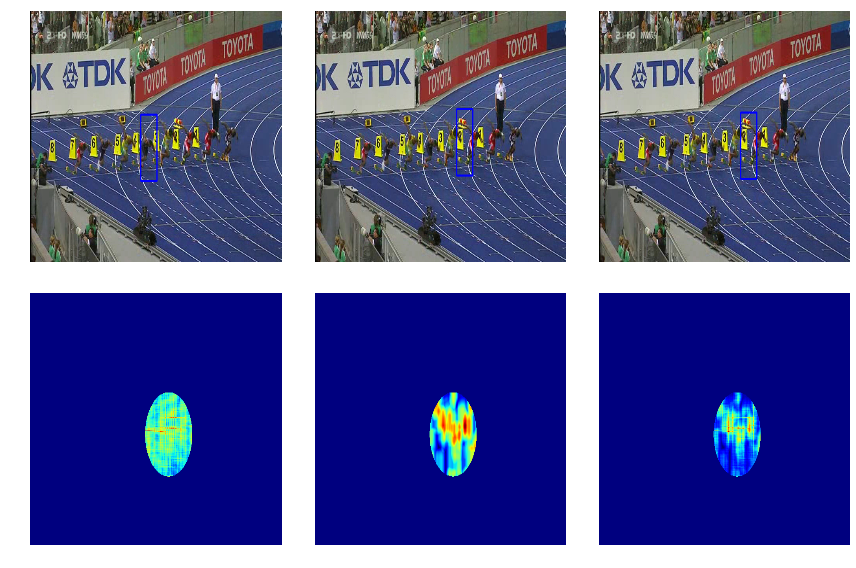

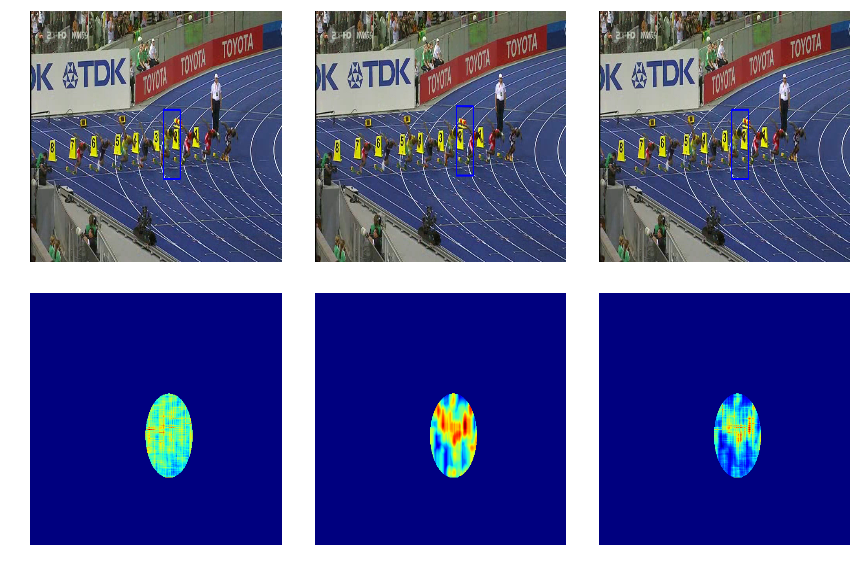

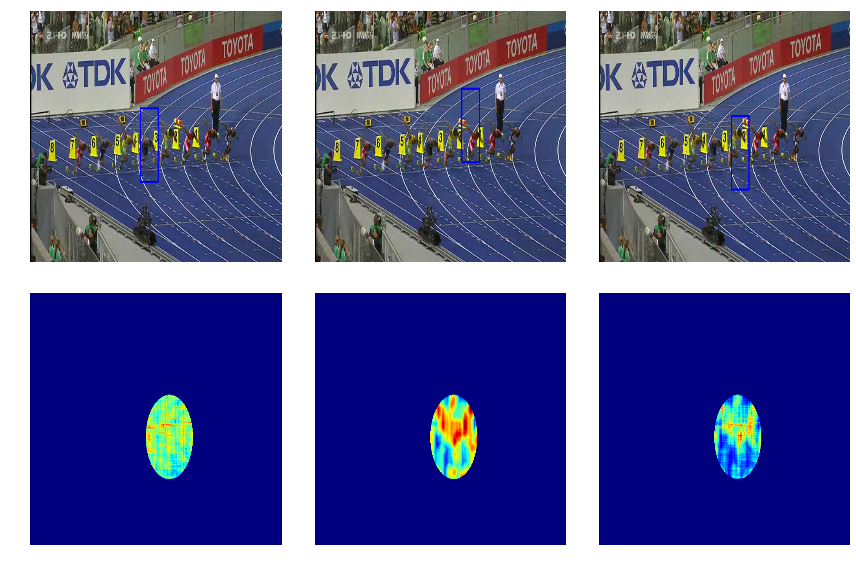

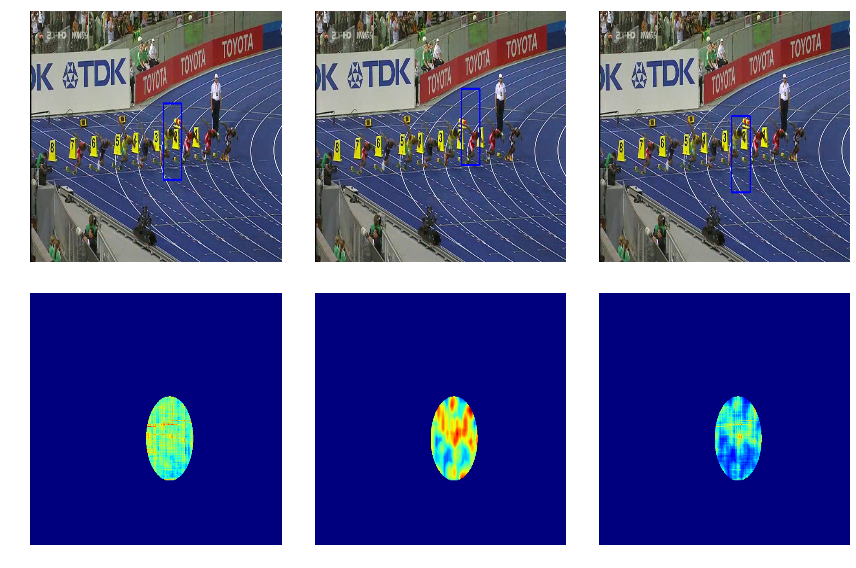

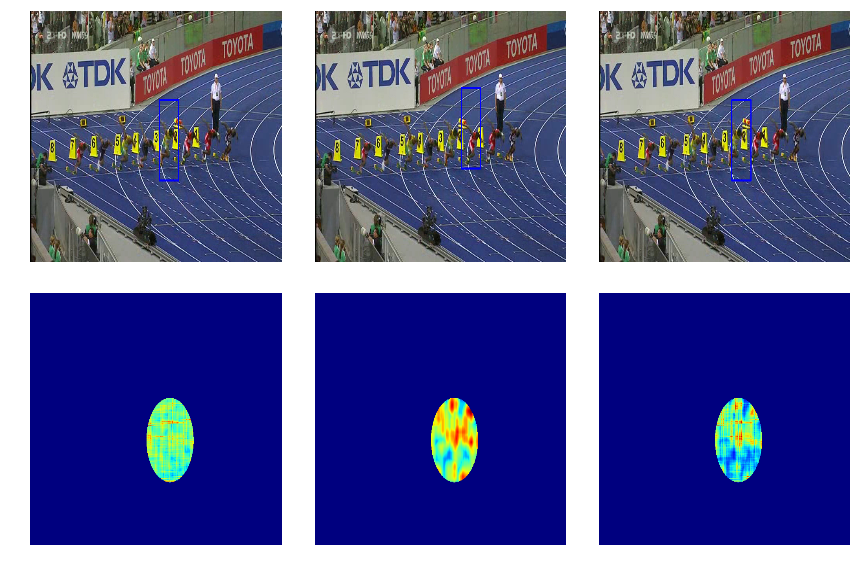

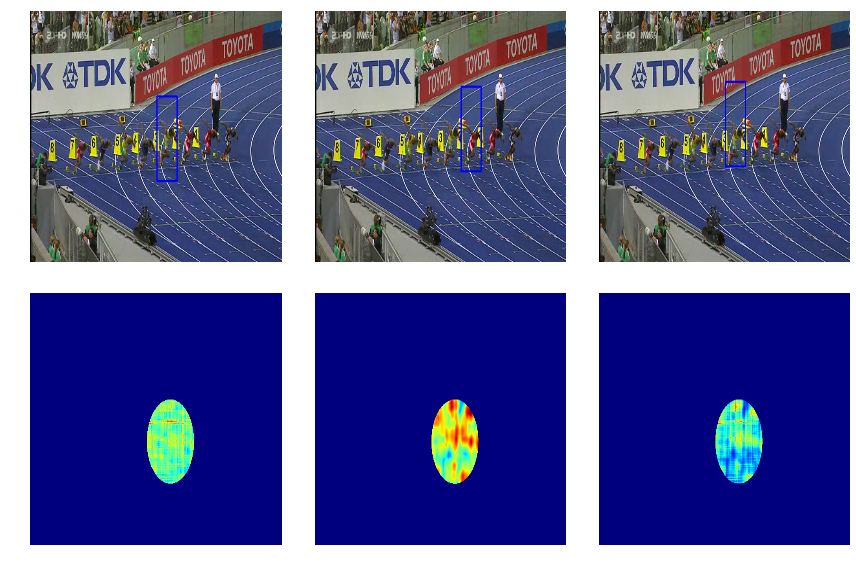

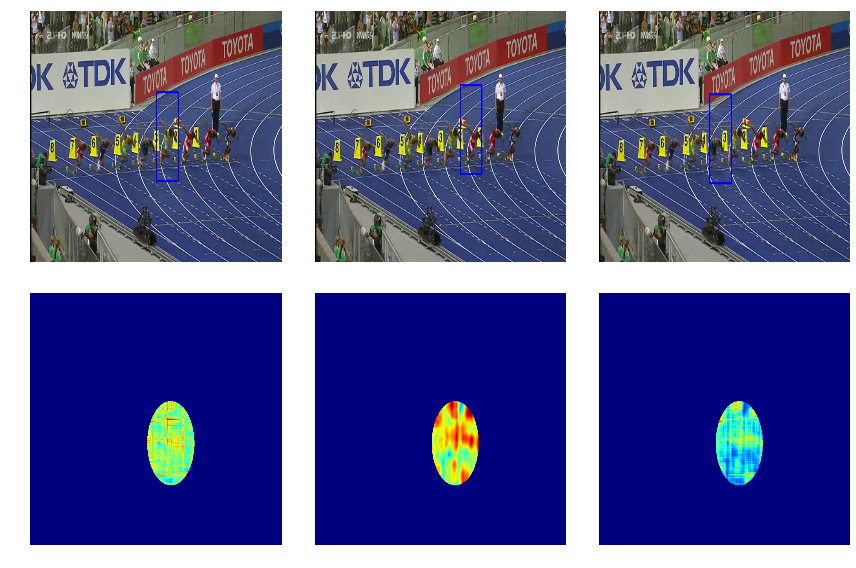

In [52]:
def getPointsFromRectangle(rect):

    pt1=(int(rect[0]),int(rect[1]))
    pt2=(int(rect[0]+rect[2]),int(rect[1]+rect[3]))
    return (pt1,pt2)

def getPtsFromCenterAndScale(x,y,scale):
    width = box[2] * np.power(scaleChange, scale);
    height = box[3] * np.power(scaleChange, scale);
    
    b_x=x-width/2.0
    b_y=y-height/2.0
    
    rect=[b_x,b_y,width,height];
    
    return getPointsFromRectangle(rect);

def getLocationMax(a):
    
    i,j = np.unravel_index(a.argmax(), a.shape)
    
    return (i,j)


O_combo=np.multiply(O_edge_copy,O_straddling_copy);

s=0;
I=cv2.imread(ImName)
I=cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
minScaleLevel=-5
maxScaleLevel=10
for idx in range(minScaleLevel,maxScaleLevel+1):
    s=idx-minScaleLevel
    plt.figure(figsize=(12,8))

    plt.subplot(2,3,1)
    image=copy.deepcopy(I)

    j,i=getLocationMax(O_edge_copy[:,:,s])
    
    (pt1,pt2)=getPtsFromCenterAndScale(i,j,s)

    cv2.rectangle(image,pt1,pt2,(0,0,255),2)
    plt.imshow(image,aspect='auto')
    plt.axis("off")
    plt.grid(b=None)

    plt.subplot(2,3,4)
    plt.imshow(O_edge_copy[:,:,s],cmap=plt.get_cmap("jet"),aspect='auto')
    plt.axis("off")
    plt.grid(b=None)


    plt.subplot(2,3,2)
    image=copy.deepcopy(I)

    j,i=getLocationMax(O_straddling_copy[:,:,s])
    (pt1,pt2)=getPtsFromCenterAndScale(i,j,s)
    cv2.rectangle(image,pt1,pt2,(0,0,255),2)
    plt.imshow(image,aspect='auto')
    plt.axis("off")
    plt.grid(b=None)

    plt.subplot(2,3,5)
    plt.imshow(O_straddling_copy[:,:,s],cmap=plt.get_cmap("jet"),aspect='auto')
    plt.axis("off")
    plt.grid(b=None)

    plt.subplot(2,3,3)
    image=copy.deepcopy(I)

    j,i=getLocationMax(O_combo[:,:,s])
    (pt1,pt2)=getPtsFromCenterAndScale(i,j,s)
    cv2.rectangle(image,pt1,pt2,(0,0,255),2)
    plt.imshow(image,aspect='auto')



    plt.axis("off")
    plt.grid(b=None)

    plt.subplot(2,3,6)
    plt.imshow(O_combo[:,:,s],cmap=plt.get_cmap("jet"),aspect='auto')
    plt.axis("off")
    plt.grid(b=None)
    plt.tight_layout()
    plt.show()